<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations.

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height.

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [2]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3
  libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 41 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://arch

## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=(c/g)h $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation. This generates a wave that will propagate to the right with speed $c$ before it encounters the seamount.

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [3]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
c = np.sqrt(g*H0) # Wave speed over the deep ocean
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1)
H.change_scales(1)
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = (g/c)*h['g']

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


2025-11-25 21:18:44,194 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


INFO:__main__:Starting main loop


2025-11-25 21:18:44,204 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-25 21:18:44,425 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 100


2025-11-25 21:18:44,427 solvers 0/1 INFO :: Final iteration: 100


INFO:solvers:Final sim time: 6000.0


2025-11-25 21:18:44,428 solvers 0/1 INFO :: Final sim time: 6000.0


INFO:solvers:Setup time (init - iter 0): 0.2945 sec


2025-11-25 21:18:44,430 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2945 sec


INFO:solvers:Warmup time (iter 0-10): 0.0618 sec


2025-11-25 21:18:44,431 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0618 sec


INFO:solvers:Run time (iter 10-end): 0.1588 sec


2025-11-25 21:18:44,433 solvers 0/1 INFO :: Run time (iter 10-end): 0.1588 sec


INFO:solvers:CPU time (iter 10-end): 4.412e-05 cpu-hr


2025-11-25 21:18:44,434 solvers 0/1 INFO :: CPU time (iter 10-end): 4.412e-05 cpu-hr


INFO:solvers:Speed: 1.158e+06 mode-stages/cpu-sec


2025-11-25 21:18:44,435 solvers 0/1 INFO :: Speed: 1.158e+06 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-25 21:18:49,409 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpe12luvr2/temp.m4v


2025-11-25 21:18:49,414 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpe12luvr2/temp.m4v


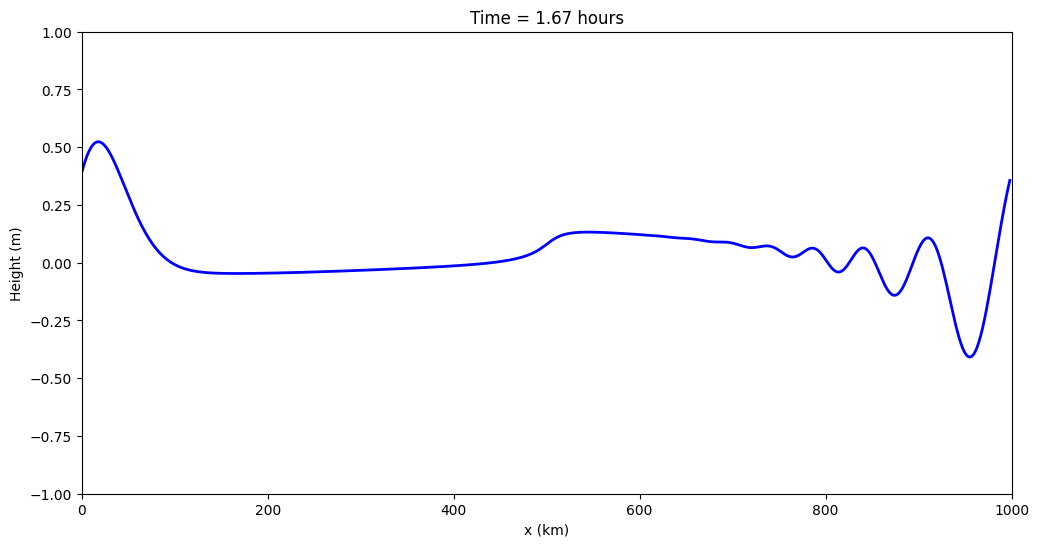

In [4]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value.

ADD EXPRESSION FOR EXPECTED WAVE SPEED AND EXPLANATION HERE

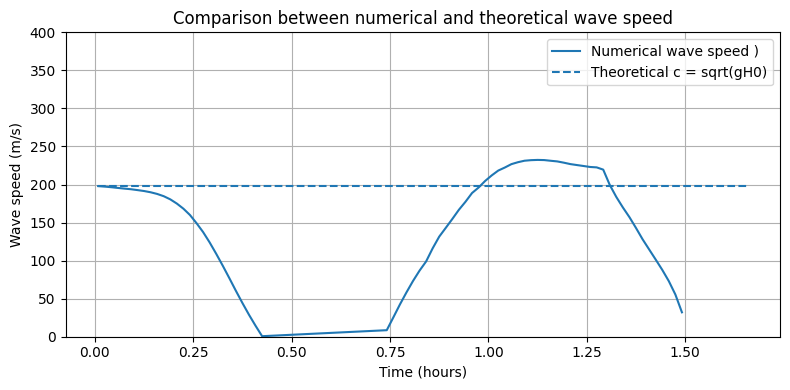

In [6]:

import numpy as np
import matplotlib.pyplot as plt

h_arr = np.array(h_save)
t_arr = np.array(t_save)
x_arr = x

h_pos = np.maximum(h_arr, 0.0)
weight_sum = np.sum(h_pos, axis=1)
x_peak = np.sum(h_pos * x_arr, axis=1) / weight_sum
t_peak = t_arr


dx = np.diff(x_peak)
dt = np.diff(t_peak)
c_num = dx / dt
t_mid = 0.5 * (t_peak[1:] + t_peak[:-1])

c_theory = np.sqrt(g*H0)

good = (c_num > 0) & (c_num < 1000)

plt.figure(figsize=(8,4))

plt.plot(t_mid[good] / hour, c_num[good],
         label='Numerical wave speed )')

plt.hlines(c_theory, t_mid[0]/hour, t_mid[-1]/hour,
           linestyles='--', label='Theoretical c = sqrt(gH0)')

plt.xlabel('Time (hours)')
plt.ylabel('Wave speed (m/s)')
plt.title('Comparison between numerical and theoretical wave speed')
plt.legend()
plt.grid(True)

plt.ylim(0, 400)

plt.tight_layout()
plt.show()



COMMENT ON RESULTS

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + \partial_x(u*H) + \partial_y(v*H)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will initilize the Tsunami with the following equation
$$ h=e^{-x^2/w_1^2} $$
$$ u=(g/c)*h $$

where $c=\sqrt{gH_0}$ and $H_0$ is the constant reference depth. The relationship between $u$ and $h$ follows from linearized shallow water equations and corresponds to a wave propagating in the $+x$ direction with a speed $c$.

We will solve the equations in a square domain with periodic boundary conditions and a Gaussian seamount in the middle of the domain with total undisturbed fluid height

$$ H=H_0 - (H_0 - H_{min})e^{-(x^2+y^2)/w_2^2} $$

The Tsunami should propagate with speed $c$ over the deep ocean where the depth is constant, but the wave will be modified as it passes over the seamount.

### 2.1  Dedalus script to solve the 2D shallow water equations

In [ ]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 1 * kilometer # minimum depth above the seamount
w1 = 50 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 60 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Qualitatively describe the influence of the seamount and explain this behavior using the shallow water equations. You can assume that the wave amplitude and velocity are small in the shallow water equations.

STUDENT ANSWER HERE (~ 1 PARAGRAPH)

Try varying some parameters (e.g. the width and height of the wave and/or seamount) and comment on the results. When does the wave no longer obey the linear shallow water equations which are valid for small waves You don't need to do a comprehensive parameter space search, but you should run several simulations with one or two parameters varied.

In [ ]:
# ADD CODE AND PLOTS HERE

STUDENT ANSWER HERE (~ 1 PARAGRAPH)

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way. In this part of the project, we will assume that the bottom of the ocean is flat and that the resting height of the ocean is a constant $H$.  

We will use Dedalus to solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [ ]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. You should modifty the code to save the height more often so that you can clearly see the shape of the wave. Notice that as the waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

ADD PLOTS AND DISCUSSION HERE

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the longitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves from the theoretical dispersion relation and compare this estimate with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

In [ ]:
# ADD CODE HERE TO SOLVE THE SHALLOW WATER EQUATIONS WITH DAMPING.
# YOU CAN START BY COPYING THE CODE ABOVE AND PASTING IT HERE

## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?